In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from label_flip_revised.utils import create_dir

/home/lukec/workspace/diva_01/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PATH_ROOT = Path(os.getcwd()).absolute().parent
print('Root:', PATH_ROOT)

Root: /home/lukec/workspace/diva_01


In [3]:
path_output = os.path.join(PATH_ROOT, 'results_plot')
print('Output:', path_output)
create_dir(path_output)

Output: /home/lukec/workspace/diva_01/results_plot


In [ ]:
def compute_threshold(df: pd.DataFrame, q: float) -> float:
    df_ = df.copy(deep=True)
    for i in np.arange(0.05, 0.5, 0.01):
        threshold = i
        results = (1 - df['Similarity']) >= threshold
        df_['Prediction'] = results.astype(int)

    return threshold

In [4]:
def get_pivot_by_difficulty(df: pd.DataFrame, q: float=0.95) -> pd.DataFrame: 
    df_ = df[['Difficulty', 'Rate', 'Similarity']]

    df_0 = df_[(df_['Difficulty'] == 'Normal') & (df_['Rate'] == 0)]
    threshold = np.quantile(df_0['Similarity'], q)
    print('Threshold:', threshold)

    # Apply the threshold
    results = df_['Similarity'] < threshold
    df_['Prediction'] = results.astype(int)

    df_ = df_.rename(columns = {'Difficulty':'Dataset Difficulty', 'Rate':'Poisoning Rate', 'Prediction': 'FPR'})
    df_grouped = df_.groupby(['Dataset Difficulty', 'Poisoning Rate']).sum()
    df_grouped = df_grouped.reset_index()
    df_pivot = df_grouped.pivot('Poisoning Rate', 'Dataset Difficulty', 'FPR')
    df_pivot = df_pivot[['Easy', 'Normal', 'Hard']]
    return df_pivot

In [5]:
THRESHOLDS = ['0.99', '0.98', '0.95', '0.90', '0.85', '0.80']

In [6]:
for q in THRESHOLDS:
    pivot_tables = []
    for att in ['falfa_nn', 'alfa_svm']:
        df_ = pd.read_csv(os.path.join(PATH_ROOT, 'results', 'synth', 'baseline', f'synth_{att}_knndefense.csv'))
        pivot_table = get_pivot_by_difficulty(df_, q=float(q))
        pivot_table.to_csv(os.path.join(path_output, f'synth_pivot_baseline_difficulty_{att}_{q}.csv'))

        pivot_table = pivot_table.reset_index()
        pivot_tables.append(pivot_table)
            
    pivot_1 = pd.concat(pivot_tables, ignore_index=True).groupby('Poisoning Rate').mean().round()
    pivot_1 = pivot_1 * 2

    # Invert the top row. The top row shows the True Negative now.
    pivot_1.loc[0.00] = 100. - pivot_1.loc[0.00]
    # Rename the top row.
    pivot_1 = pivot_1.rename(index={0.00: 'Clean'})

    pivot_1.to_csv(os.path.join(path_output, f'heatmap_diff_baseline_{q}.csv'))
    print(pivot_1)

Threshold: 0.902541
Threshold: 0.902541
Dataset Difficulty  Easy  Normal   Hard
Poisoning Rate                         
Clean               82.0     2.0    0.0
0.05                52.0   100.0  100.0
0.1                 74.0   100.0  100.0
0.15                80.0   100.0  100.0
0.2                 84.0   100.0  100.0
0.25                88.0   100.0  100.0
0.3                 92.0   100.0  100.0
0.35                88.0   100.0  100.0
0.4                 90.0   100.0  100.0
Threshold: 0.898082
Threshold: 0.898082
Dataset Difficulty  Easy  Normal   Hard
Poisoning Rate                         
Clean               88.0     2.0    0.0
0.05                48.0   100.0  100.0
0.1                 72.0   100.0  100.0
0.15                76.0   100.0  100.0
0.2                 84.0   100.0  100.0
0.25                88.0   100.0  100.0
0.3                 92.0   100.0  100.0
0.35                88.0   100.0  100.0
0.4                 90.0   100.0  100.0
Threshold: 0.89284
Threshold: 0.89284
Da

In [7]:
def get_pivot_by_noise(df: pd.DataFrame, train_noise_lvl=0, q: float=0.95) -> pd.DataFrame: 
    df_ = df[['Noise', 'Rate', 'Similarity']]

    df_0 = df_[(df['Rate'] == 0) & (df_['Rate'] <= train_noise_lvl)]
    threshold = np.quantile(df_0['Similarity'], q)
    print('Threshold:', threshold)

    # Apply the threshold
    results = df_['Similarity'] < threshold
    df_['Prediction'] = results.astype(int)

    df_ = df_.rename(columns = {'Noise':'Noise Label Rate', 'Rate':'Poisoning Rate', 'Prediction': 'FPR'})
    df_grouped = df_.groupby(['Noise Label Rate', 'Poisoning Rate']).sum()
    df_grouped = df_grouped.reset_index()
    df_pivot = df_grouped.pivot('Poisoning Rate', 'Noise Label Rate', 'FPR')
    return df_pivot

In [8]:
for q in THRESHOLDS:
    pivot_tables = []
    for att in ['falfa_nn', 'alfa_svm']:
        df_ = pd.read_csv(os.path.join(PATH_ROOT, 'results', 'synth_noisy', 'baseline', f'synth_{att}_knndefense.csv'))
        pivot_table = get_pivot_by_noise(df_, q=float(q))
        pivot_table.to_csv(os.path.join(path_output, f'synth_pivot_baseline_noisy_{att}_{q}.csv'))

        pivot_table = pivot_table.reset_index()
        pivot_tables.append(pivot_table)
            
    pivot_2 = pd.concat(pivot_tables, ignore_index=True).groupby('Poisoning Rate').mean().round()
    pivot_2 = pivot_2 * 2

    # Same modification as Pivot Table 1
    pivot_2.loc[0.00] = 100. - pivot_2.loc[0.00]
    pivot_2 = pivot_2.rename(index={0.00: 'Clean'})

    pivot_2.to_csv(os.path.join(path_output, f'heatmap_noise_baseline_{q}.csv'), index=True)
    print(pivot_2)

Threshold: 0.945977
Threshold: 0.945977
Noise Label Rate   0.0   0.05    0.1   0.15    0.2   0.25    0.3   0.35    0.4
Poisoning Rate                                                                
Clean              8.0    2.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
0.05              98.0   98.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0
0.1               98.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0
0.15              98.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0
0.2               98.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0
0.25              98.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0
0.3               98.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0
0.35              98.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0
0.4               98.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0
Threshold: 0.9138639999999998
Threshold: 0.9138639999999998
Noise Label Rate   0.0   0.05  

Save to: /home/lukec/workspace/diva_01/results_plot/synth_heatmap_baseline_0.99.svg
Save to: /home/lukec/workspace/diva_01/results_plot/synth_heatmap_baseline_0.98.svg
Save to: /home/lukec/workspace/diva_01/results_plot/synth_heatmap_baseline_0.95.svg
Save to: /home/lukec/workspace/diva_01/results_plot/synth_heatmap_baseline_0.90.svg
Save to: /home/lukec/workspace/diva_01/results_plot/synth_heatmap_baseline_0.85.svg
Save to: /home/lukec/workspace/diva_01/results_plot/synth_heatmap_baseline_0.80.svg


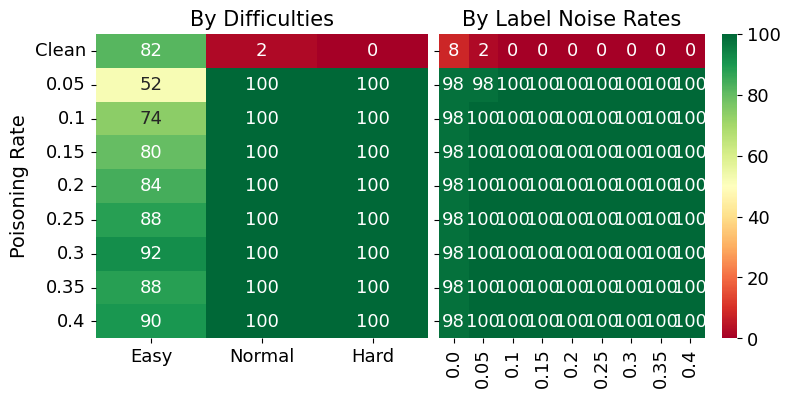

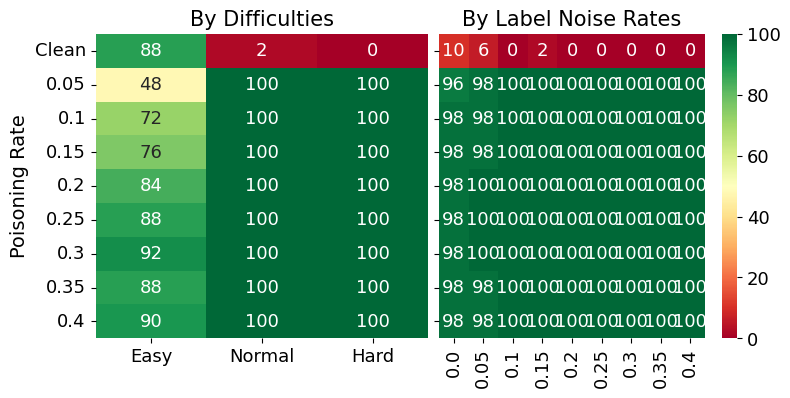

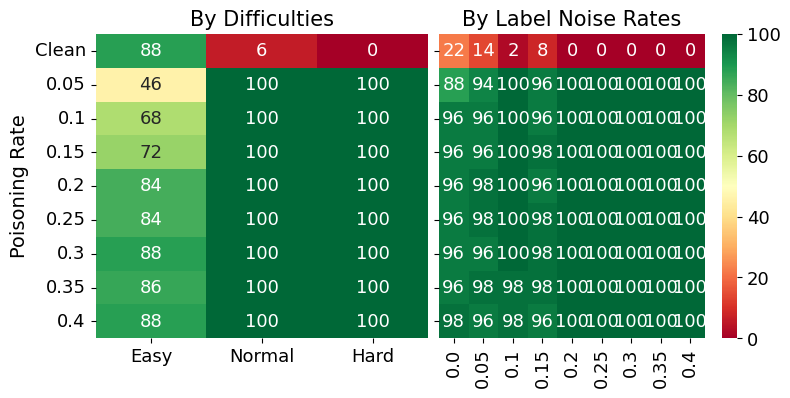

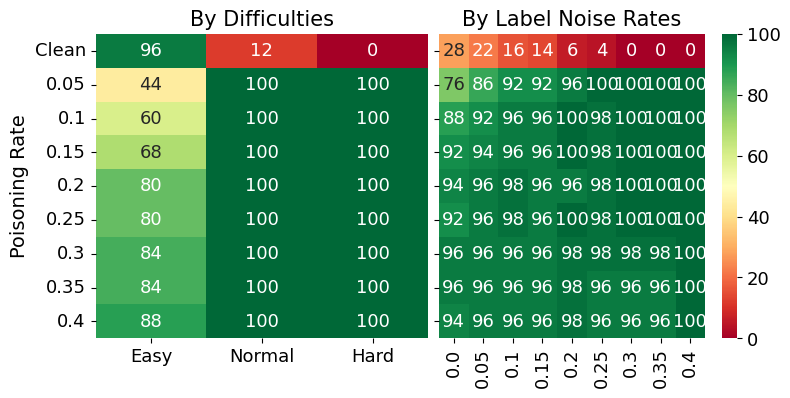

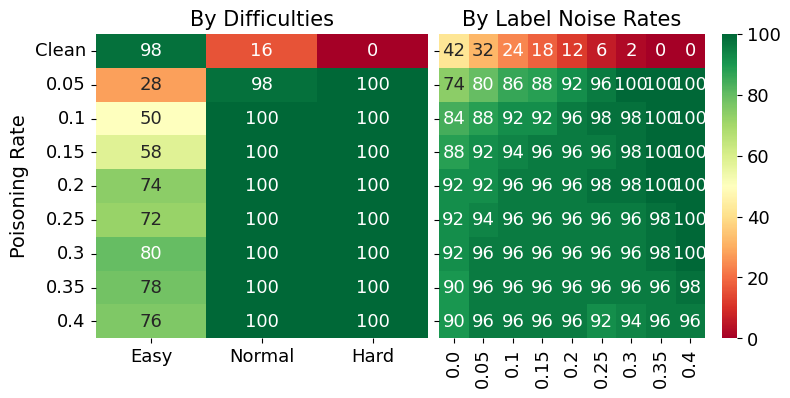

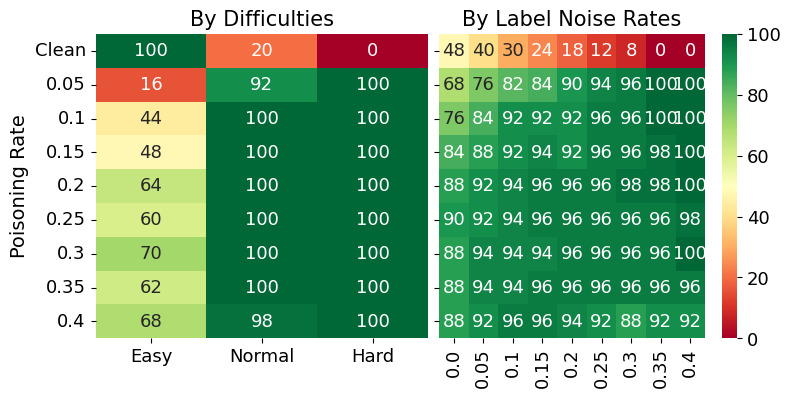

In [9]:
# Baseline subfigures at top row
# Keep subtitles, but remove X labels

FONTSIZE = 13
FIGSIZE = (8, 4)
# X_LABELS = ['Dataset Difficulty', 'Label Noise Rate']
TITLES = ['By Difficulties', 'By Label Noise Rates']
CMAP = 'RdYlGn'

plt.rcParams["font.size"] = FONTSIZE

for q in THRESHOLDS:
    # Load results
    pivot_1 = pd.read_csv(os.path.join(path_output, f'heatmap_diff_baseline_{q}.csv'), index_col="Poisoning Rate")
    pivot_2 = pd.read_csv(os.path.join(path_output, f'heatmap_noise_baseline_{q}.csv'), index_col="Poisoning Rate")

    fig, axes = plt.subplots(1, 2, sharey=True, figsize=FIGSIZE)

    sns.heatmap(pivot_1, ax=axes[0], annot=True, fmt='.0f', cmap=CMAP, vmin=0, vmax=100, cbar=False)
    axes[0].set_ylabel('Poisoning Rate', fontsize=FONTSIZE+1)

    sns.heatmap(pivot_2, ax=axes[1], annot=True, fmt='.0f', cmap=CMAP, vmin=0, vmax=100)
    axes[1].set_ylabel('')

    for i, ax in enumerate(axes):
        # ax.set_xlabel(X_LABELS[i], fontsize=FONTSIZE+1)
        ax.set(xlabel=None)
        ax.set_title(TITLES[i], fontsize=FONTSIZE+2)

    plt.tight_layout(pad=0.6)
    plot_heatmap = os.path.join(path_output, f'synth_heatmap_baseline_{q}.svg')
    plt.savefig(plot_heatmap, dpi=300)
    print(f'Save to: {plot_heatmap}')